In [6]:
# Lightly adapted from https://github.com/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb


def mask_generate(url="../homelab-status-page/static/webcam.jpg"):
    # using_colab = False
    # if using_colab:
    #     import torch
    #     import torchvision
    #     print("PyTorch version:", torch.__version__)
    #     print("Torchvision version:", torchvision.__version__)
    #     print("CUDA is available:", torch.cuda.is_available())
    #     import sys
    #     !{sys.executable} -m pip install opencv-python matplotlib
    #     !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything-2.git'
    
    #     !mkdir -p images
    #     !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything-2/main/notebooks/images/cars.jpg
    
    #     !mkdir -p ../checkpoints/
    #     !wget -P ../checkpoints/ https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt
    
    import os
    # if using Apple MPS, fall back to CPU for unsupported ops
    os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
    import numpy as np
    import torch
    import matplotlib.pyplot as plt
    from PIL import Image
    
    # select the device for computation
    if torch.cuda.is_available():
        device = torch.device("cuda")
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
    print(f"using device: {device}")
    
    if device.type == "cuda":
        # use bfloat16 for the entire notebook
        torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
        # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
        if torch.cuda.get_device_properties(0).major >= 8:
            torch.backends.cuda.matmul.allow_tf32 = True
            torch.backends.cudnn.allow_tf32 = True
    elif device.type == "mps":
        print(
            "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
            "give numerically different outputs and sometimes degraded performance on MPS. "
            "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
        )
    
    np.random.seed(3)
    
    def show_anns(anns, borders=True):
        if len(anns) == 0:
            return
        sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
        ax = plt.gca()
        ax.set_autoscale_on(False)
    
        img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
        img[:, :, 3] = 0
        for ann in sorted_anns:
            m = ann['segmentation']
            color_mask = np.concatenate([np.random.random(3), [0.5]])
            img[m] = color_mask 
            if borders:
                import cv2
                contours, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
                # Try to smooth contours
                contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
                cv2.drawContours(img, contours, -1, (0, 0, 1, 0.4), thickness=1) 
    
        ax.imshow(img)
    
    image = Image.open(url)
    image = np.array(image.convert("RGB"))
    
    plt.figure(figsize=(20, 20))
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    
    from sam2.build_sam import build_sam2
    from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator
    
    sam2_checkpoint = "./sam2_hiera_tiny.pt"
    model_cfg = "sam2_hiera_t.yaml"
    
    sam2 = build_sam2(model_cfg, sam2_checkpoint, device=device, apply_postprocessing=False)
    
    mask_generator = SAM2AutomaticMaskGenerator(sam2)
    
    masks = mask_generator.generate(image)
    
    print(len(masks))
    print(masks[0].keys())
    
    plt.figure(figsize=(20, 20))
    plt.imshow(image)
    show_anns(masks)
    plt.axis('off')
    plt.show()
    
    mask_generator_2 = SAM2AutomaticMaskGenerator(
        model=sam2,
        points_per_side=64,
        points_per_batch=128,
        pred_iou_thresh=0.7,
        stability_score_thresh=0.92,
        stability_score_offset=0.7,
        crop_n_layers=1,
        box_nms_thresh=0.7,
        crop_n_points_downscale_factor=2,
        min_mask_region_area=25.0,
        use_m2m=True,
    )
    
    masks2 = mask_generator_2.generate(image)
    
    plt.figure(figsize=(20, 20))
    plt.imshow(image)
    show_anns(masks2)
    plt.axis('off')
    plt.show()

In [8]:
! micromamba info


       libmamba version : 1.5.9
     micromamba version : 1.5.9
           curl version : libcurl/8.9.1 OpenSSL/3.3.1 zlib/1.3.1 zstd/1.5.6 libssh2/1.11.0 nghttp2/1.58.0
     libarchive version : libarchive 3.7.4 zlib/1.2.13 bz2lib/1.0.8 libzstd/1.5.6
       envs directories : /home/adnan/micromamba/envs
          package cache : /home/adnan/micromamba/pkgs
                          /home/adnan/.mamba/pkgs
            environment : sam (active)
           env location : /home/adnan/micromamba/envs/sam
      user config files : /home/adnan/.mambarc
 populated config files : /home/adnan/.condarc
       virtual packages : __unix=0=0
                          __linux=6.8.0=0
                          __glibc=2.39=0
                          __archspec=1=x86_64-v3
                          __cuda=12.2=0
               channels : https://conda.anaconda.org/conda-forge/linux-64
                          https://conda.anaconda.org/conda-forge/noarch
                          https://conda.ana



mask_generate()

using device: cuda


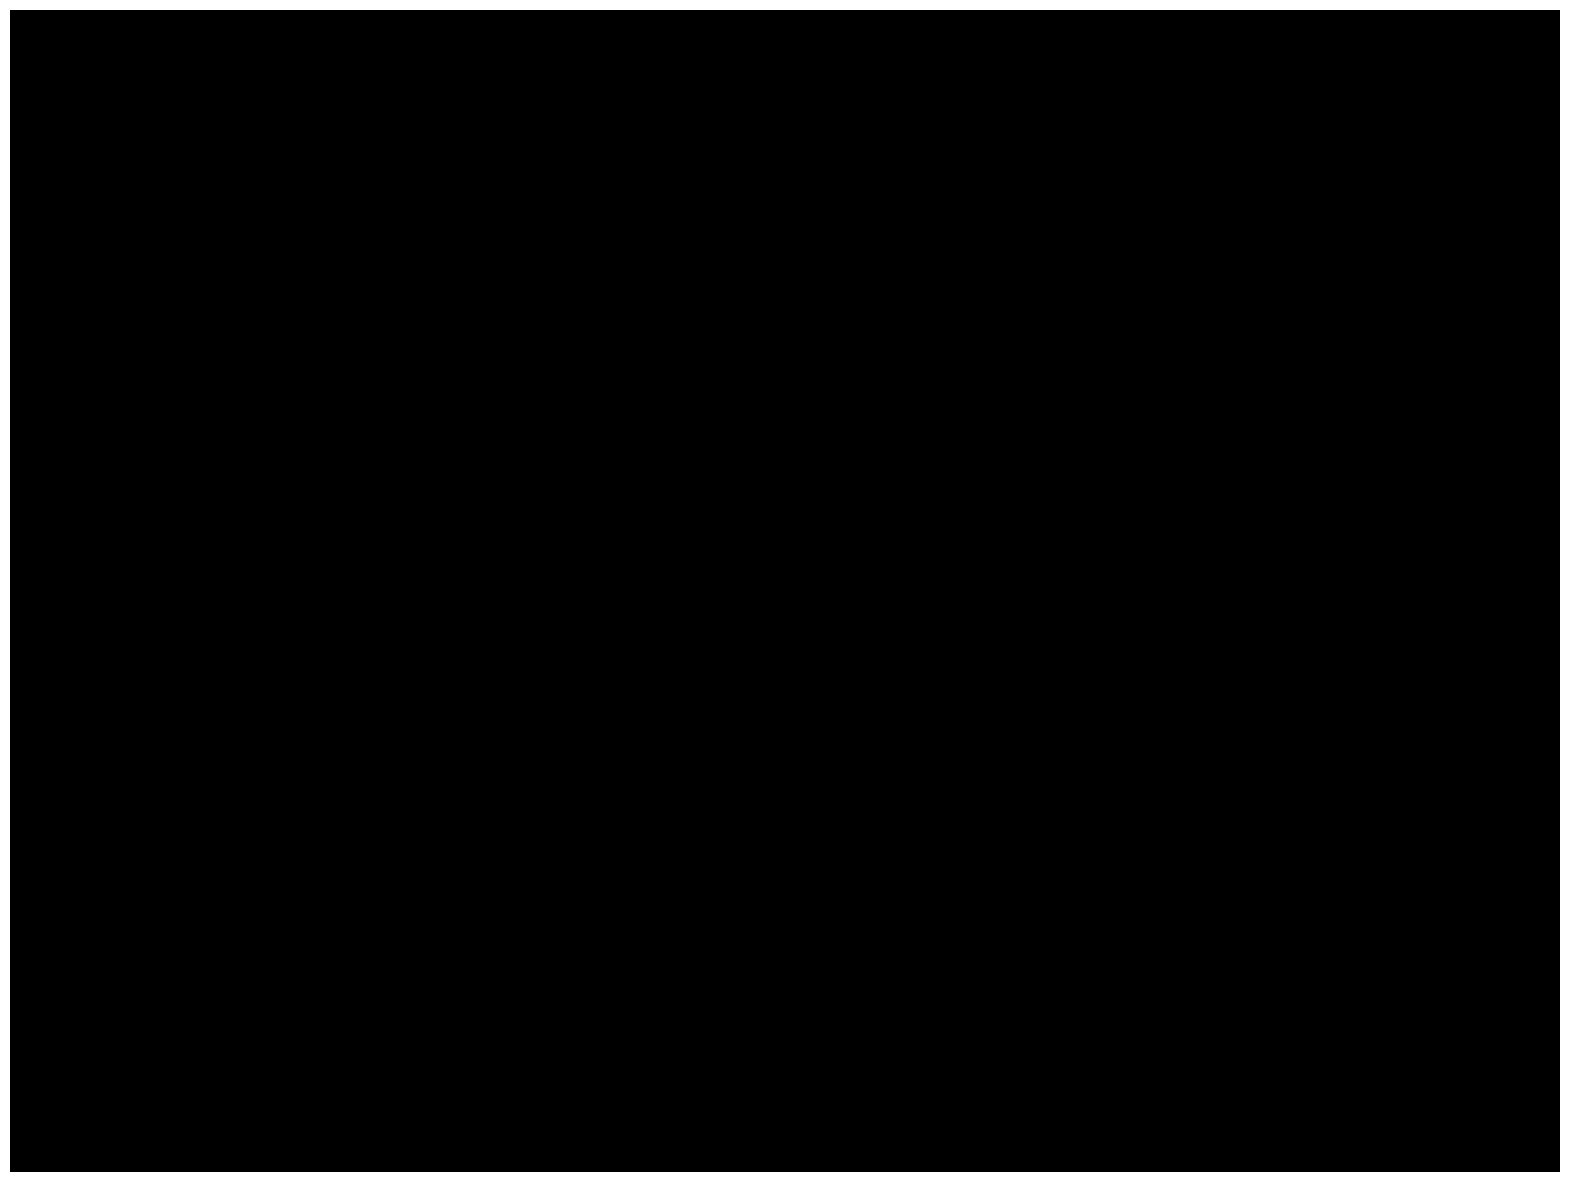

1
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


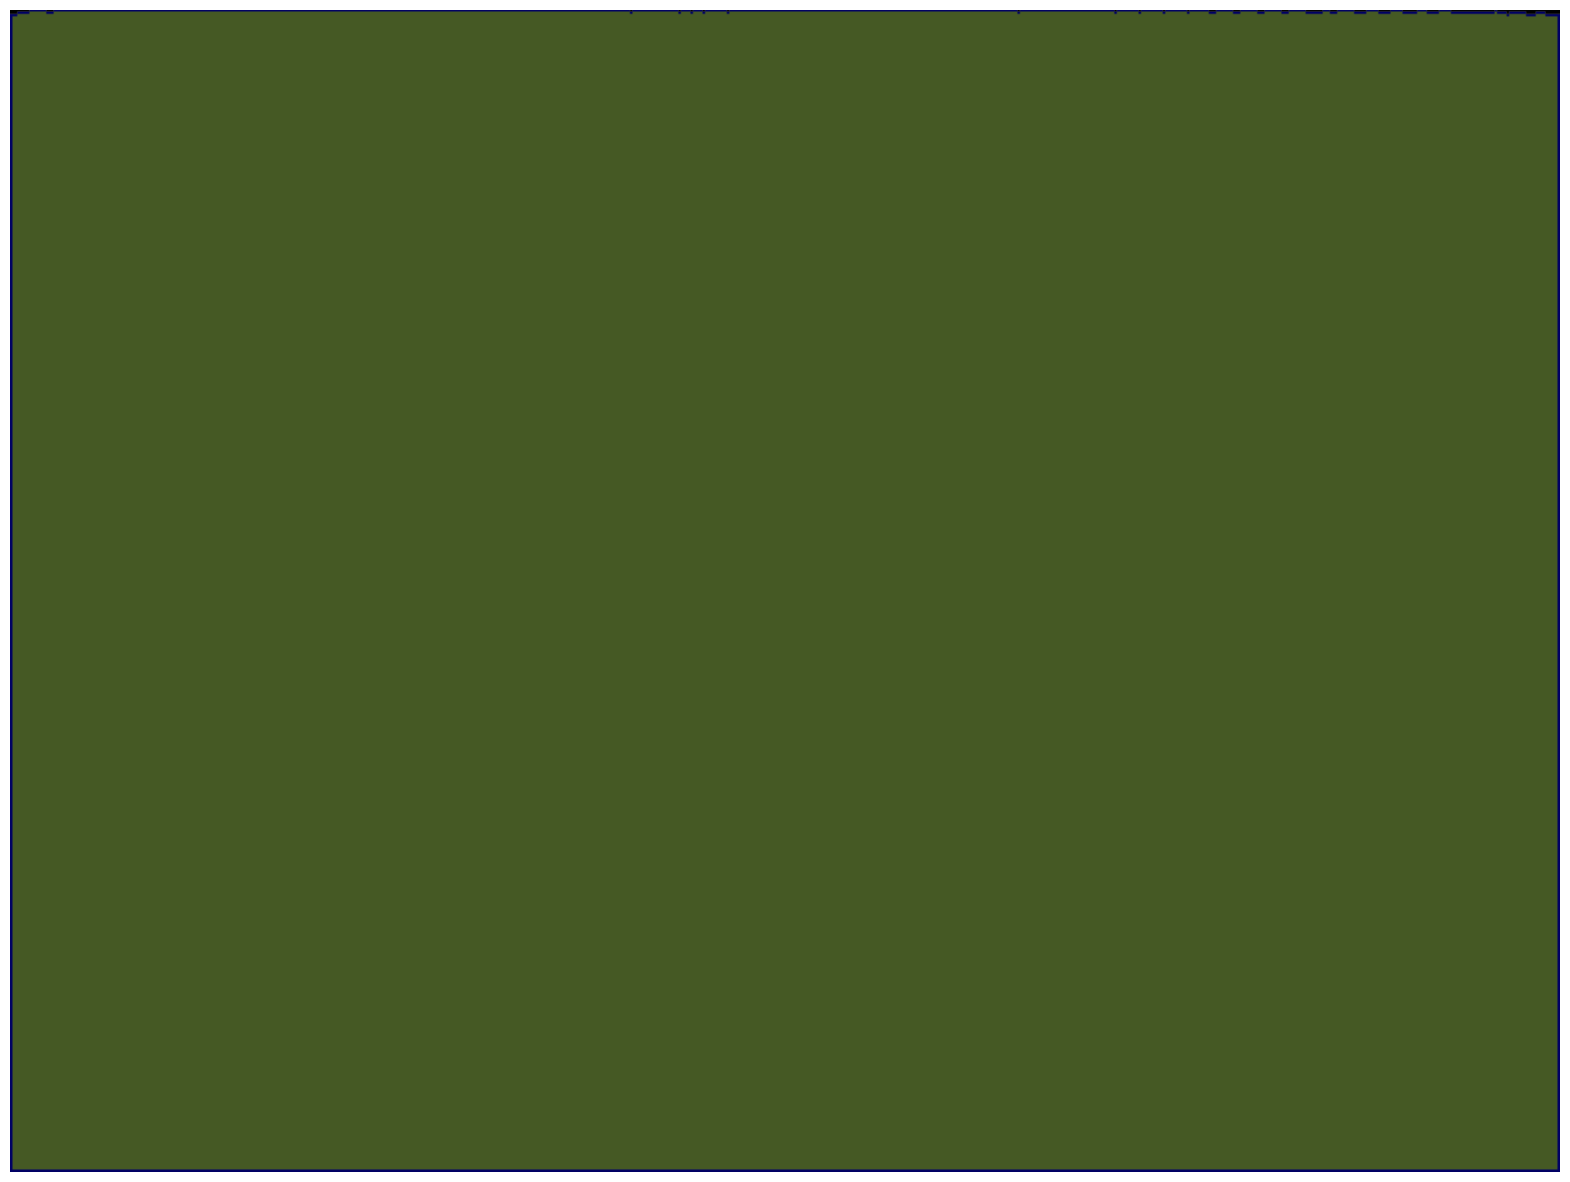

/home/adnan/hashirama/services/perception-stack/sam2/sam2_image_predictor.py:431: UserWarning: cannot import name '_C' from 'sam2' (/home/adnan/hashirama/services/perception-stack/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/segment-anything-2/blob/main/INSTALL.md).
  masks = self._transforms.postprocess_masks(


IndexError: too many indices for tensor of dimension 1

In [7]:
mask_generate()

In [ ]:
import os

os.listdir('../homelab-status-page/static/')

In [31]:

from PIL import Image, ImageOps
import os
# horizontal / vertical notebook - diffrent views on same data - annotaiton
# Define paths
# Expand '~' to the full user path
# input_image_path = os.path.expanduser(input_image_path)
# output_image_path = os.path.expanduser(output_image_path)

input_image_path = os.path.expanduser("~/hashirama/services/homelab-status-page/static/webcam.jpg")
output_image_path = os.path.expanduser("~/hashirama/services/homelab-status-page/static/jupyter_webcam.jpg")
#input_image_path = 'https://hashirama.blog/static/webcam.jpg'
#https://hashirama.blog/static/jupyter_webcam.jpg";

# Open the image

def overwrite_img():
    with Image.open(input_image_path) as img:
        # Flip the image (horizontally or vertically)
        flipped_img = ImageOps.mirror(img)  # Horizontal flip
        # Invert the colors of the image
        inverted_img = ImageOps.invert(flipped_img.convert("RGB"))
        
        # Save the modified image
        inverted_img.save(output_image_path)

    print(f"Processed image saved to {output_image_path}")
overwrite_img()

Processed image saved to /home/adnan/hashirama/services/homelab-status-page/static/jupyter_webcam.jpg


In [2]:

show_masks(image, masks, scores, point_coords=input_point, input_labels=input_label, borders=True)

input_point = np.array([[500, 375], [1125, 625]])
input_label = np.array([1, 1])

mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask

masks, scores, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)

masks.shape

show_masks(image, masks, scores, point_coords=input_point, input_labels=input_label)

input_point = np.array([[500, 375], [1125, 625]])
input_label = np.array([1, 0])

mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask

masks, scores, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)

show_masks(image, masks, scores, point_coords=input_point, input_labels=input_label)

input_box = np.array([425, 600, 700, 875])
masks, scores, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

show_masks(image, masks, scores, box_coords=input_box)

input_box = np.array([425, 600, 700, 875])
input_point = np.array([[575, 750]])
input_label = np.array([0])

masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    box=input_box,
    multimask_output=False,
)

show_masks(image, masks, scores, box_coords=input_box, point_coords=input_point, input_labels=input_label)

input_boxes = np.array([
    [75, 275, 1725, 850],
    [425, 600, 700, 875],
    [1375, 550, 1650, 800],
    [1240, 675, 1400, 750],
])
masks, scores, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_boxes,
    multimask_output=False,
)
masks.shape  # (batch_size) x (num_predicted_masks_per_input) x H x W

plt.figure(figsize=(10, 10))
plt.imshow(image)
for mask in masks:
    show_mask(mask.squeeze(0), plt.gca(), random_color=True)
for box in input_boxes:
    show_box(box, plt.gca())
plt.axis('off')
plt.show()

image1 = image  # truck.jpg from above
image1_boxes = np.array([
    [75, 275, 1725, 850],
    [425, 600, 700, 875],
    [1375, 550, 1650, 800],
    [1240, 675, 1400, 750],
])

image2 = Image.open('./notebooks/images/groceries.jpg')
image2 = np.array(image2.convert("RGB"))

NameError: name 'show_masks' is not defined

In [3]:
import  os

os.listdir('.')

['output.gif',
 'CONTRIBUTING.md',
 'checkpoints',
 '.clang-format',
 '.env',
 'yolov8n.pt',
 'runs',
 'README.md',
 'semantic_segmentation.ipynb',
 'Kay_How.pdf.1',
 'sam2',
 '.venv',
 'SAM_2.egg-info',
 'CODE_OF_CONDUCT.md',
 'LICENSE',
 'pyproject.toml',
 'assets',
 'sav_dataset',
 'datasets',
 'view?usp=sharing',
 'Kay_How.pdf',
 'sam2_configs',
 '.ipynb_checkpoints',
 'happydream.ipynb',
 'bus.jpg',
 '.github',
 'LICENSE_cctorch',
 'replicate.ipynb',
 'notebooks',
 'scratch.ipynb',
 'lottie_gif.ipynb',
 'tools',
 'INSTALL.md',
 'setup.py',
 'yolov8n.onnx']

In [9]:
import json
import requests

def get_notebook_code_from_github(url):
    # Get the notebook content from the GitHub URL
    response = requests.get(url)
    notebook = response.json()

    # Initialize a list to store code cells
    code_cells = []

    # Loop through cells and extract code
    for cell in notebook['cells']:
        if cell['cell_type'] == 'code':
            code_cells.append("".join(cell['source']))

    return code_cells

# Example usage
# url = 'https://raw.githubusercontent.com/facebookresearch/segment-anything-2/main/notebooks/image_predictor_example.ipynb'
# code = get_notebook_code_from_github(url)
# for cell in code:
#     print(cell)


In [10]:

#! bash checkpoints/download_ckpts.sh

using device: cuda


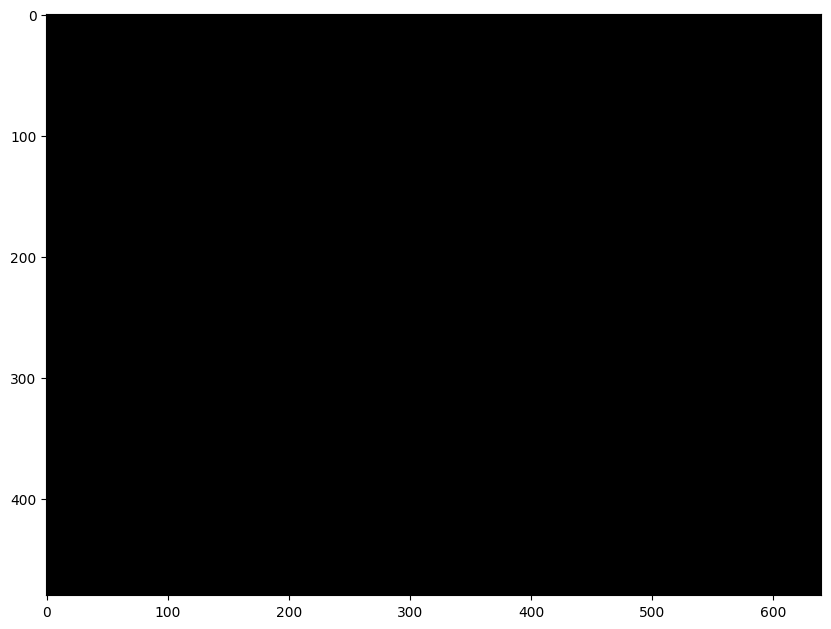

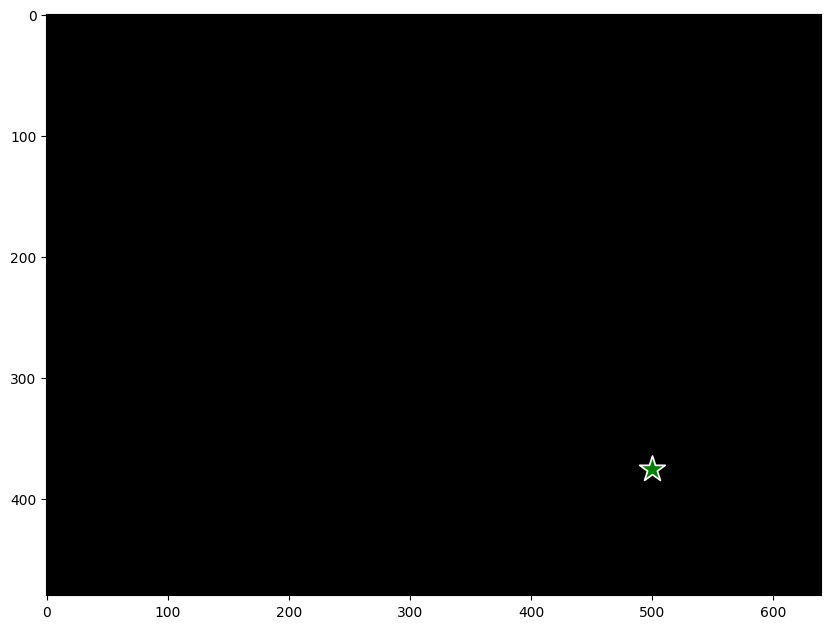

torch.Size([1, 256, 64, 64]) torch.Size([256, 64, 64])


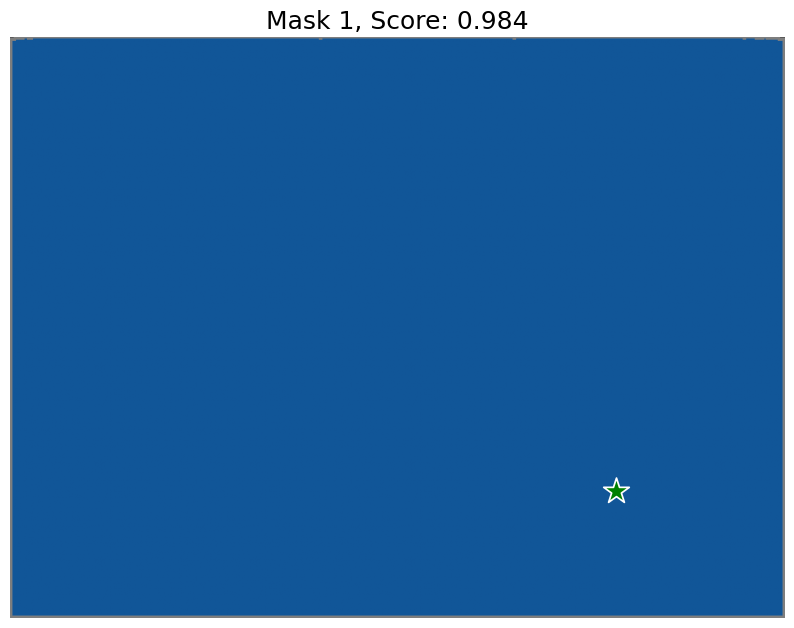

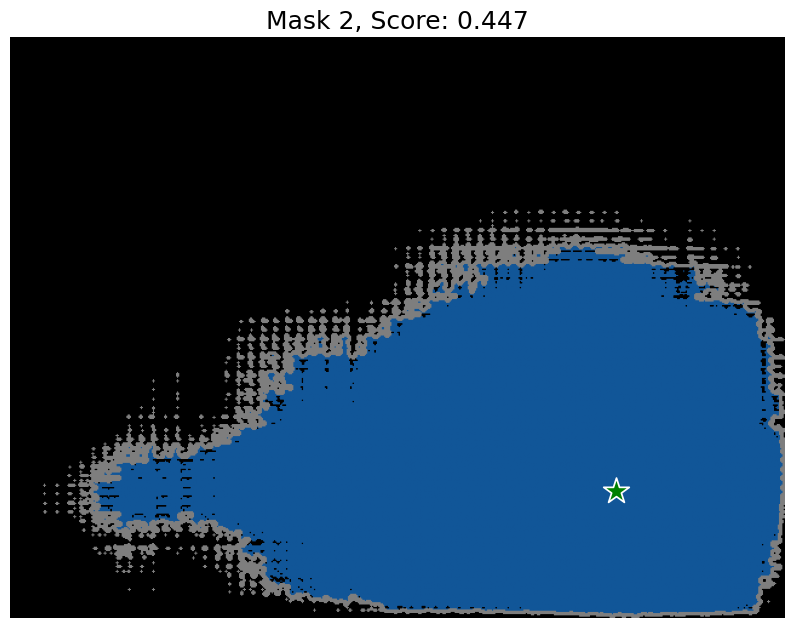

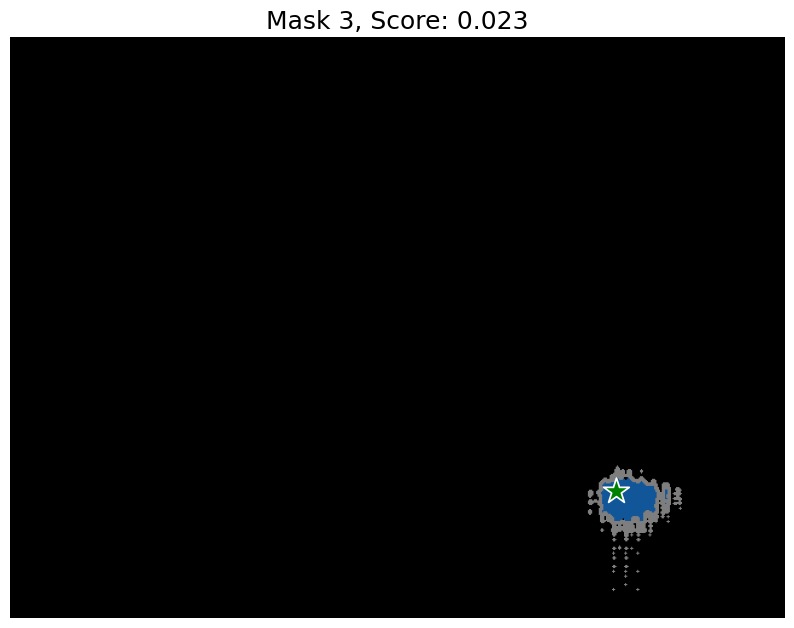

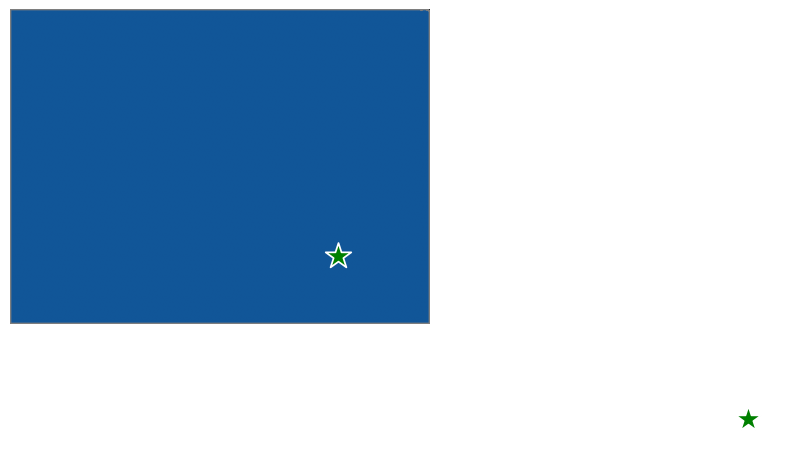

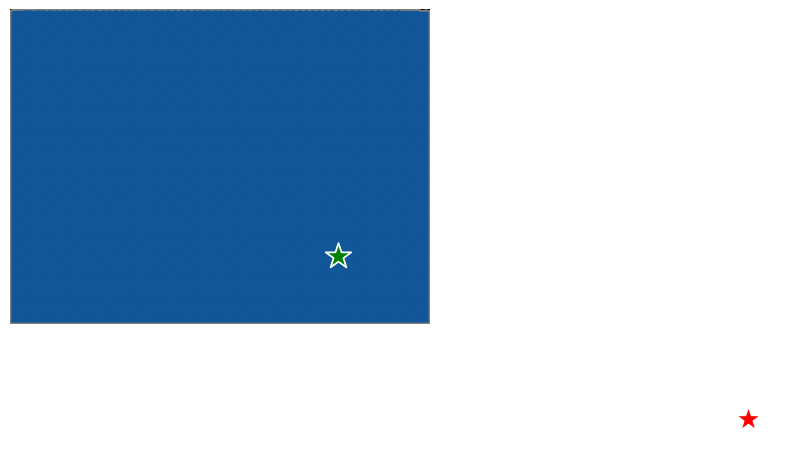

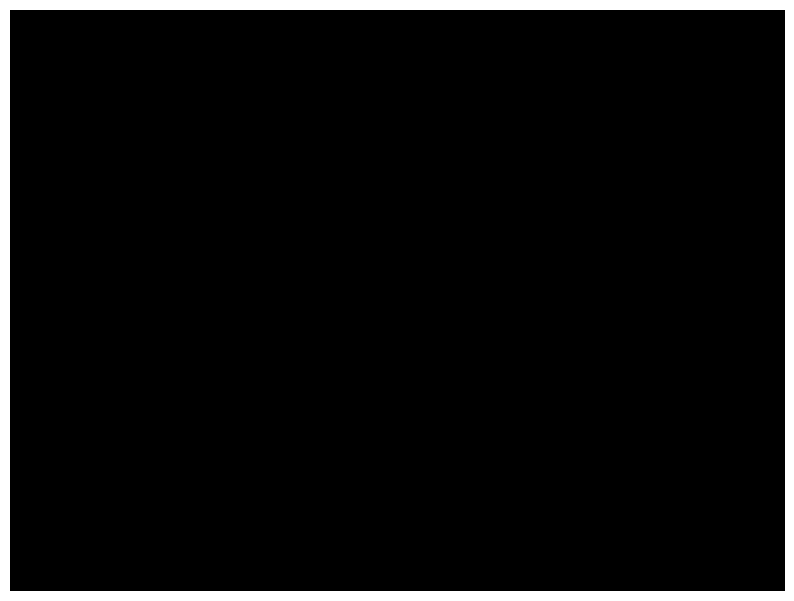

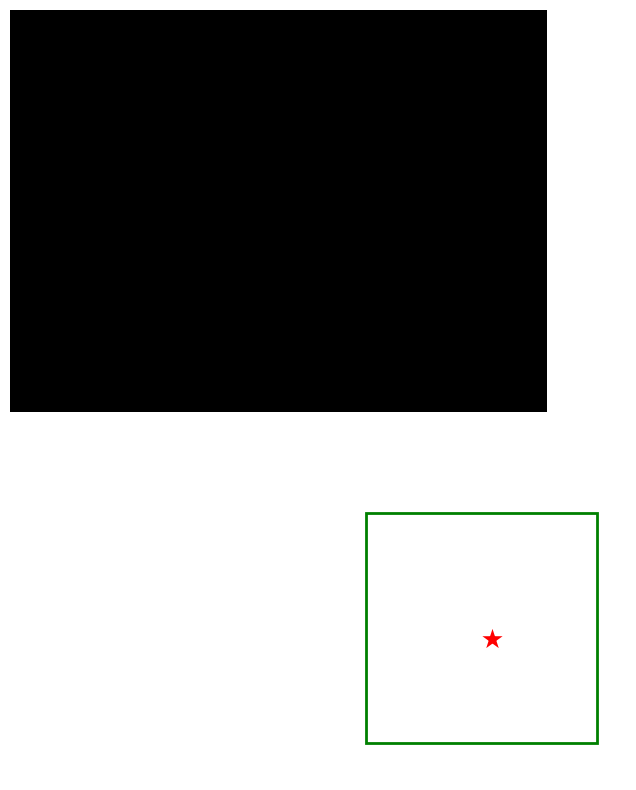

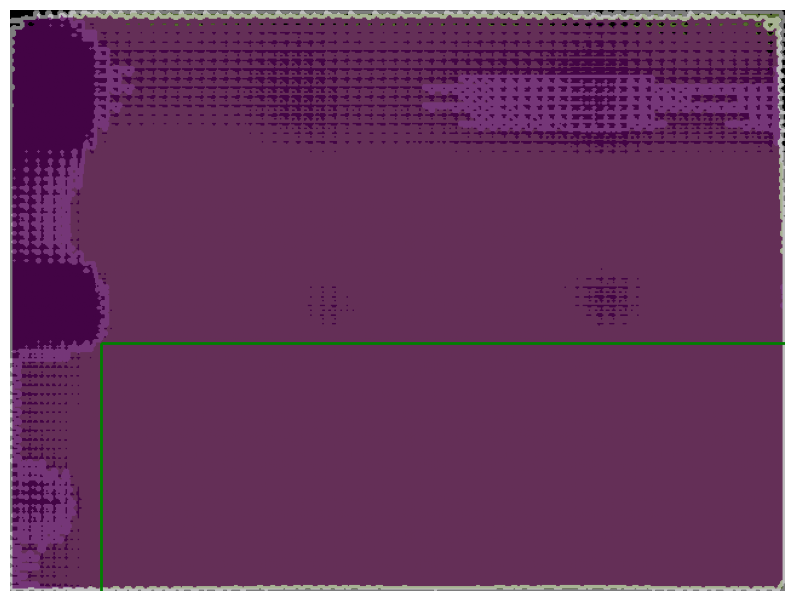

0

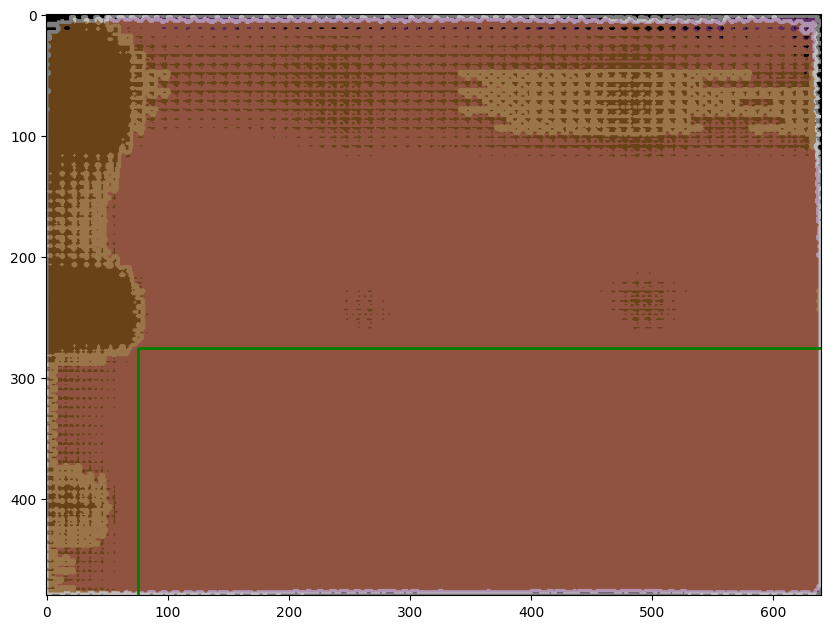

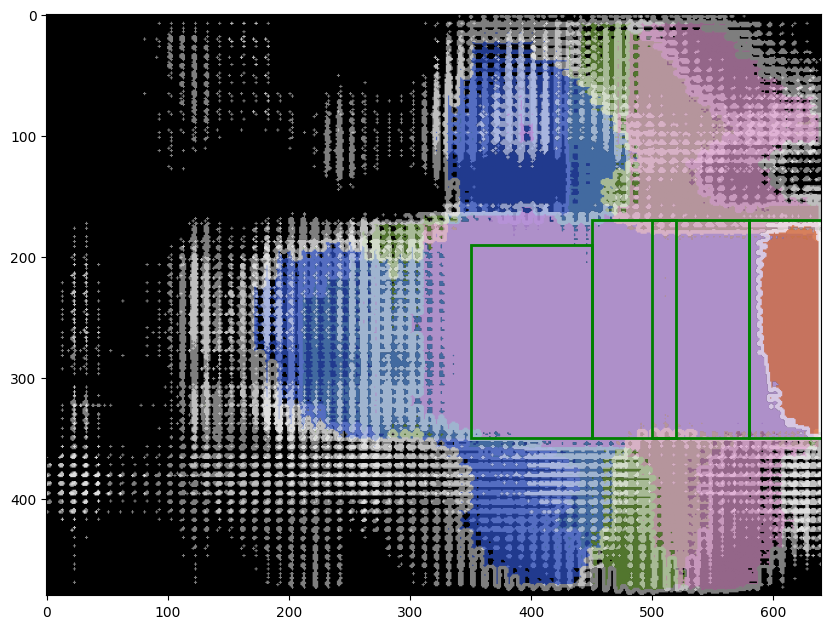

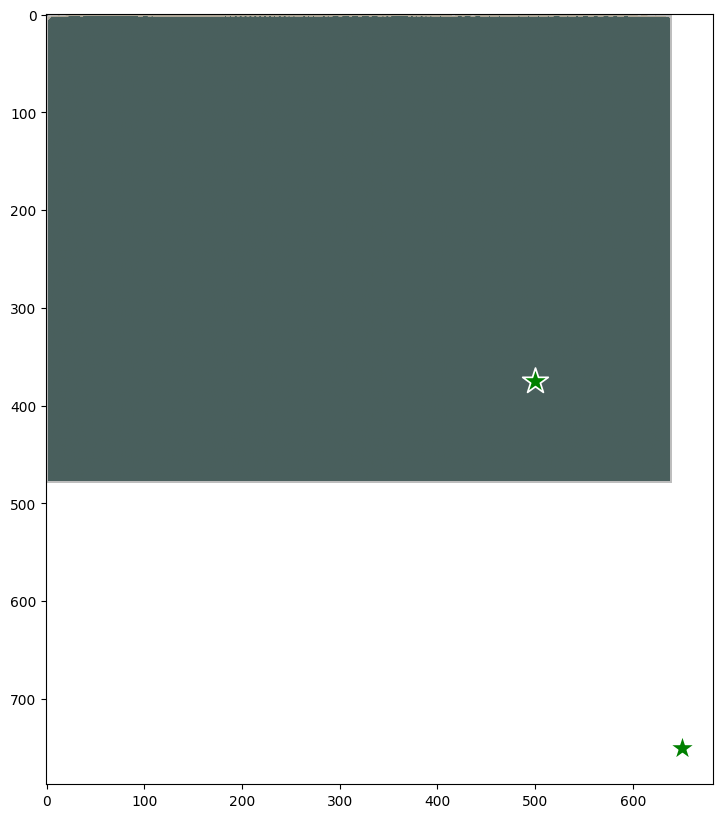

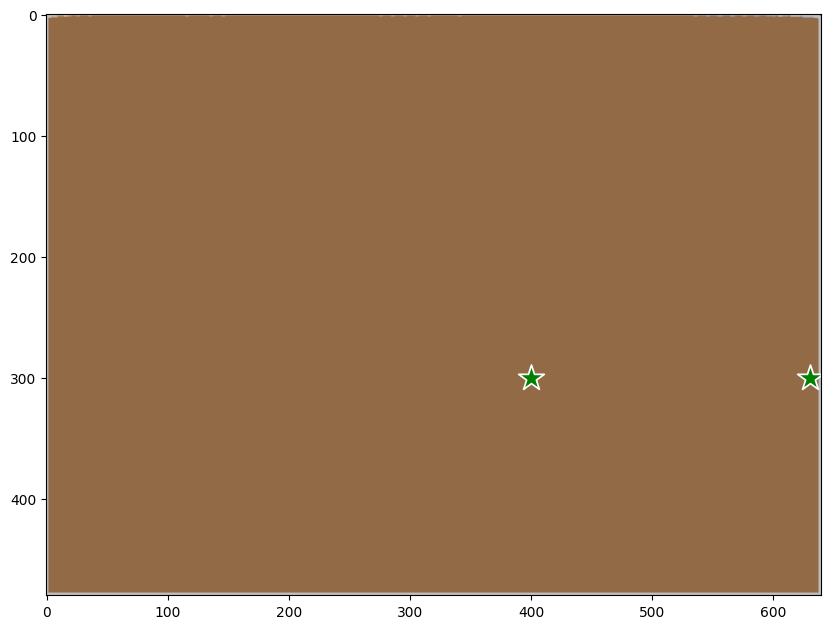

In [5]:
image_predictor()

In [4]:
# Copyright (c) Meta Platforms, Inc. and affiliates.
def image_predictor(url="../homelab-status-page/static/webcam.jpg"):
    
    using_colab = False
    if using_colab:
        import torch
        import torchvision
        print("PyTorch version:", torch.__version__)
        print("Torchvision version:", torchvision.__version__)
        print("CUDA is available:", torch.cuda.is_available())
        import sys
        !{sys.executable} -m pip install opencv-python matplotlib
        !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything-2.git'
    
        !mkdir -p images
        !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything-2/main/notebooks/images/truck.jpg
        !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything-2/main/notebooks/images/groceries.jpg
    
        !mkdir -p ../checkpoints/
        !wget -P ../checkpoints/ https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt
    import os
    # if using Apple MPS, fall back to CPU for unsupported ops
    os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
    import numpy as np
    import torch
    import matplotlib.pyplot as plt
    from PIL import Image
    # select the device for computation
    if torch.cuda.is_available():
        device = torch.device("cuda")
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
    print(f"using device: {device}")
    
    if device.type == "cuda":
        # use bfloat16 for the entire notebook
        torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
        # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
        if torch.cuda.get_device_properties(0).major >= 8:
            torch.backends.cuda.matmul.allow_tf32 = True
            torch.backends.cudnn.allow_tf32 = True
    elif device.type == "mps":
        print(
            "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
            "give numerically different outputs and sometimes degraded performance on MPS. "
            "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
        )
    np.random.seed(3)
    
    def show_mask(mask, ax, random_color=False, borders = True):
        if random_color:
            color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
        else:
            color = np.array([30/255, 144/255, 255/255, 0.6])
        h, w = mask.shape[-2:]
        mask = mask.astype(np.uint8)
        mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
        if borders:
            import cv2
            contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
            # Try to smooth contours
            contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
            mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2) 
        ax.imshow(mask_image)
    
    def show_points(coords, labels, ax, marker_size=375):
        pos_points = coords[labels==1]
        neg_points = coords[labels==0]
        ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
        ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
    def show_box(box, ax):
        x0, y0 = box[0], box[1]
        w, h = box[2] - box[0], box[3] - box[1]
        ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))    
    
    def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
        for i, (mask, score) in enumerate(zip(masks, scores)):
            plt.figure(figsize=(10, 10))
            plt.imshow(image)
            show_mask(mask, plt.gca(), borders=borders)
            if point_coords is not None:
                assert input_labels is not None
                show_points(point_coords, input_labels, plt.gca())
            if box_coords is not None:
                # boxes
                show_box(box_coords, plt.gca())
            if len(scores) > 1:
                plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
            plt.axis('off')
            plt.show()
    image = Image.open(url)
    image = np.array(image.convert("RGB"))
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis('on')
    
    
    plt.show()
    
    from sam2.build_sam import build_sam2
    from sam2.sam2_image_predictor import SAM2ImagePredictor
    
    sam2_checkpoint = "sam2_hiera_tiny.pt"
    model_cfg = "sam2_hiera_t.yaml"
    
    sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)
    
    predictor = SAM2ImagePredictor(sam2_model)
    predictor.set_image(image)
    input_point = np.array([[500, 375]])
    input_label = np.array([1])
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    show_points(input_point, input_label, plt.gca())
    plt.axis('on')
    plt.show()  
    print(predictor._features["image_embed"].shape, predictor._features["image_embed"][-1].shape)
    masks, scores, logits = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=True,
    )
    sorted_ind = np.argsort(scores)[::-1]
    masks = masks[sorted_ind]
    scores = scores[sorted_ind]
    logits = logits[sorted_ind]
    masks.shape  # (number_of_masks) x H x W
    show_masks(image, masks, scores, point_coords=input_point, input_labels=input_label, borders=True)
    input_point = np.array([[500, 375], [1125, 625]])
    input_label = np.array([1, 1])
    
    mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask
    masks, scores, _ = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        mask_input=mask_input[None, :, :],
        multimask_output=False,
    )
    masks.shape
    show_masks(image, masks, scores, point_coords=input_point, input_labels=input_label)
    input_point = np.array([[500, 375], [1125, 625]])
    input_label = np.array([1, 0])
    
    mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask
    masks, scores, _ = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        mask_input=mask_input[None, :, :],
        multimask_output=False,
    )
    show_masks(image, masks, scores, point_coords=input_point, input_labels=input_label)
    input_box = np.array([425, 600, 700, 875])
    masks, scores, _ = predictor.predict(
        point_coords=None,
        point_labels=None,
        box=input_box[None, :],
        multimask_output=False,
    )
    show_masks(image, masks, scores, box_coords=input_box)
    input_box = np.array([425, 600, 700, 875])
    input_point = np.array([[575, 750]])
    input_label = np.array([0])
    masks, scores, logits = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        box=input_box,
        multimask_output=False,
    )
    show_masks(image, masks, scores, box_coords=input_box, point_coords=input_point, input_labels=input_label)
    input_boxes = np.array([
        [75, 275, 1725, 850],
        [425, 600, 700, 875],
        [1375, 550, 1650, 800],
        [1240, 675, 1400, 750],
    ])
    masks, scores, _ = predictor.predict(
        point_coords=None,
        point_labels=None,
        box=input_boxes,
        multimask_output=False,
    )
    masks.shape  # (batch_size) x (num_predicted_masks_per_input) x H x W
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    for mask in masks:
        show_mask(mask.squeeze(0), plt.gca(), random_color=True)
    for box in input_boxes:
        show_box(box, plt.gca())
    plt.axis('off')
    plt.show()
    image1 = image  # truck.jpg from above
    image1_boxes = np.array([
        [75, 275, 1725, 850],
        [425, 600, 700, 875],
        [1375, 550, 1650, 800],
        [1240, 675, 1400, 750],
    ])
    
    image2 = Image.open(url)
    image2 = np.array(image2.convert("RGB"))
    image2_boxes = np.array([
        [450, 170, 520, 350],
        [350, 190, 450, 350],
        [500, 170, 580, 350],
        [580, 170, 640, 350],
    ])
    
    img_batch = [image1, image2]
    boxes_batch = [image1_boxes, image2_boxes]
    predictor.set_image_batch(img_batch)
    masks_batch, scores_batch, _ = predictor.predict_batch(
        None,
        None, 
        box_batch=boxes_batch, 
        multimask_output=False
    )
    for image, boxes, masks in zip(img_batch, boxes_batch, masks_batch):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)   
        for mask in masks:
            show_mask(mask.squeeze(0), plt.gca(), random_color=True)
        for box in boxes:
            show_box(box, plt.gca())
    image1 = image  # truck.jpg from above
    image1_pts = np.array([
        [[500, 375]],
        [[650, 750]]
        ]) # Bx1x2 where B corresponds to number of objects 
    image1_labels = np.array([[1], [1]])
    
    image2_pts = np.array([
        [[400, 300]],
        [[630, 300]],
    ])
    image2_labels = np.array([[1], [1]])
    
    pts_batch = [image1_pts, image2_pts]
    labels_batch = [image1_labels, image2_labels]
    masks_batch, scores_batch, _ = predictor.predict_batch(pts_batch, labels_batch, box_batch=None, multimask_output=True)
    
    # Select the best single mask per object
    best_masks = []
    for masks, scores in zip(masks_batch,scores_batch):
        best_masks.append(masks[range(len(masks)), np.argmax(scores, axis=-1)])
    for image, points, labels, masks in zip(img_batch, pts_batch, labels_batch, best_masks):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)   
        for mask in masks:
            show_mask(mask, plt.gca(), random_color=True)
        show_points(points, labels, plt.gca())
    return 0